## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

import time

import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "None"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
"""Code Here
建立你的神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

EARLYSTOP_PATIENCE = [5, 10, 25]

#1 試改變 monitor "Validation Accuracy" 並比較結果
#2 調整 earlystop 的等待次數至 10, 25 並比較結果

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
earlystop = {}
for patience in EARLYSTOP_PATIENCE:
    earlystop[patience] = EarlyStopping(monitor = "val_accuracy",
                                        patience = patience,
                                        verbose = 1
                                       )
    print(earlystop[patience])
print(earlystop)

{5: <keras.callbacks.callbacks.EarlyStopping object at 0x000001C09C2005F8>, 10: <keras.callbacks.callbacks.EarlyStopping object at 0x000001C09C2006D8>, 25: <keras.callbacks.callbacks.EarlyStopping object at 0x000001C09C200710>}


In [8]:
results = {}
t1 = time.time()
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for patience in EARLYSTOP_PATIENCE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("\n", "="*50)
    print(f"EARLYSTOP_PATIENCE = {patience}\n")
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=[earlystop[patience]]
             )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    result_tag = f"Patience-{str(patience)}"
    results[result_tag] = {'train-loss': train_loss,
                           'valid-loss': valid_loss,
                           'train-acc': train_acc,
                           'valid-acc': valid_acc}
t2 = time.time()
print(f"\ntotal time: {t2-t1} seconds \n")


EARLYSTOP_PATIENCE = 5

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 150us/step - loss: 2.1982 - accuracy: 0.2760 - val_loss: 2.1479 - val_accuracy: 0.1875
Epoch 2/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.7517 - accuracy: 0.3918 - val_loss: 1.9838 - val_accuracy: 0.2810
Epoch 3/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.6233 - accuracy: 0.4339 - val_loss: 1.8419 - val_accuracy: 0.3532
Epoch 4/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.5492 - accuracy: 0.4570 - val_loss: 1.7295 - val_accuracy: 0.3989
Epoch 5/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.4930 - accuracy: 0.4772 - val_loss: 1.6620 - val_accuracy: 0.4190
Epoch 6/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.4475 - accuracy: 0.4935 - val_loss: 1.6026 - val_accuracy: 0.4383
Epoch 7/50
50000/50000 [==============================] - 7s 1

50000/50000 [==============================] - 7s 138us/step - loss: 1.6153 - accuracy: 0.4358 - val_loss: 1.8343 - val_accuracy: 0.3554
Epoch 4/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.5421 - accuracy: 0.4609 - val_loss: 1.7393 - val_accuracy: 0.3837
Epoch 5/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.4876 - accuracy: 0.4803 - val_loss: 1.6643 - val_accuracy: 0.4127
Epoch 6/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.4439 - accuracy: 0.4998 - val_loss: 1.6044 - val_accuracy: 0.4342
Epoch 7/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.4037 - accuracy: 0.5119 - val_loss: 1.5731 - val_accuracy: 0.4388
Epoch 8/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.3677 - accuracy: 0.5248 - val_loss: 1.5409 - val_accuracy: 0.4561
Epoch 9/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.3368 - accuracy: 0.5356 - val_loss: 1.514

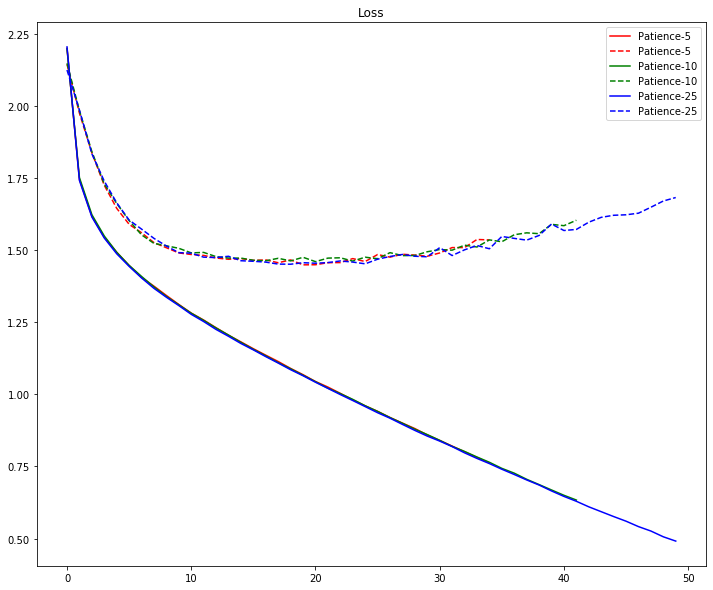

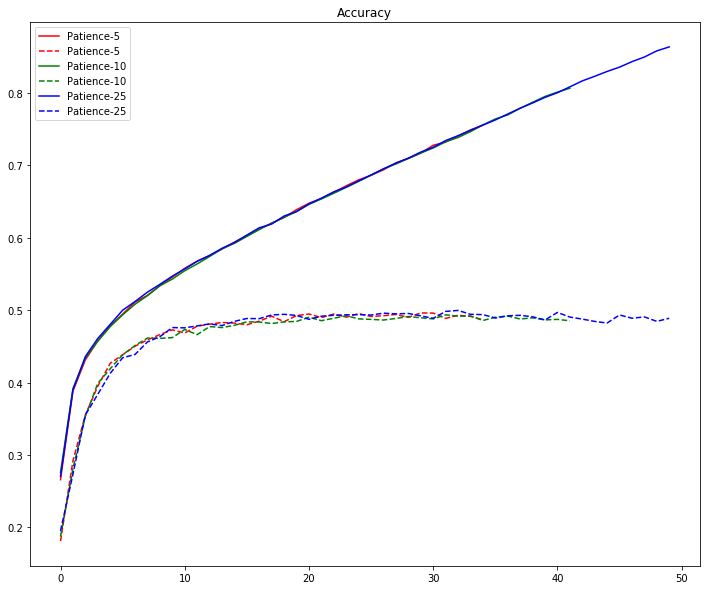

In [9]:
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])

plt.title("Loss")
#plt.ylim([0, 5])
plt.legend(loc = 'upper right')
plt.show()
    
plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])

plt.title("Accuracy")
plt.legend(loc = 'upper left')
plt.show()
